In [2]:
import logging
import os
import pathlib
import subprocess
import warnings

from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr

# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
# Generating the path to the project directory
project_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'martin-fire')

# Create the project directory
os.makedirs(project_dir, exist_ok=True)

project_dir

'/home/jovyan/earth-analytics/data/martin-fire'

In [15]:
martin_gdf = gpd.read_file(
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services"
    "/Historic_Geomac_Perimeters_2018/FeatureServer/0/query"
    "?where=incidentname%20%3D%20'MARTIN'%20AND%20latest%20%3D%20'Y'"
    "%20AND%20agency%20%3D%20'BLM'&outFields=*&outSR=4326&f=json"
)

martin_gdf

,OBJECTID,agency,comments,active,mapmethod,datecurrent,uniquefireidentifier,fireyear,incidentname,pooownerunit,...,incomplex,complexfirecode,mergeid,latest,modifiedon,createdon,temp,shape__Area,shape__Length,geometry
0,5310,BLM,NIFC FTP; Refined using Sentinel 2 imagery,N,Digitized-Image,1535328000000,2018-NVHUMX-020170,2018,Martin,NVPRI,...,N,,,Y,NaN,NaN,NaN,3.129725e+09,1.091822e+06,"POLYGON ((-117.44561 41.60593, -117.44510 41.6..."


In [22]:
# Paradise Valley, NV location 
# From https://www.usclimatedata.com/map/USNV0074
paradise_lat = 41.500260
paradis_lon = - 117.241679

# Create a Folium map object
m = folium.Map(
    location=[paradise_lat, paradis_lon], 
    zoom_start=10,
    scrollWheelZoom=False,
    tiles ='Stamen Watercolor')     

# Convert the GeoDataFrame to GeoJSON format
martin_geojson = martin_gdf.to_json()

# Add the GeoJSON data to the map as a GeoJson layer
martin_style = {
        "fillColor": "red",
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    }
folium.GeoJson(
    martin_geojson, 
    style_function = lambda feature: martin_style
    ).add_to(m)

# Add a marker for Paradise Valley, NV
folium.Marker(location= [paradise_lat, paradis_lon]).add_to(m)

# Display the map
m

In [24]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key='modis-ndvi',
    ea_dir=project_dir,
    product='MYD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date='06-01',
    end_date='08-31',
    recurring=True,
    year_range=[2017, 2022],
    polygon=martin_gdf
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

ndvi_downloader

INFO:root:Submitting task request...
INFO:root:Logging into AppEEARS API...
INFO:root:Login successful. Auth Header: Bearer rB2FU6JQZ7cR0-wgAv6QlSsI0BQa7MUUuC_WkTx8-3iH3U0JLtYoydhKFVBhnNKx4m4IiuPOFOoH_9zIkwSx4w
INFO:root:task request successfully completed
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:queued
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:queued
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:queued
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:queued
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:queued
INFO:root:Submitting status/{task_id} request...
INFO:root:status/{task_id} request successfully completed
INFO:root:queued

In [25]:
ndvi_path_list = glob(os.path.join(
    ndvi_downloader.data_dir, '*', '*NDVI*.tif'))

ndvi_path_list

['/home/jovyan/earth-analytics/data/martin-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2019137_aid0001.tif',
 '/home/jovyan/earth-analytics/data/martin-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2018185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/martin-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2017169_aid0001.tif',
 '/home/jovyan/earth-analytics/data/martin-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2020185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/martin-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2020233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/martin-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy2021185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/martin-fire/modis-ndvi/MYD13Q1.061_2017137_to_2022243/MYD13Q1.061__250m_16_days_NDVI_doy

In [26]:
doy_start = -19
doy_end = -12
scale_factor = 10000

ndvi_da_list = []
for ndvi_path in ndvi_path_list:

    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor

    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

ndvi_da_list

[<xarray.DataArray 'NDVI' (date: 1, y: 201, x: 514)>
 array([[[0.4054, 0.4054, 0.4054, ..., 0.148 , 0.122 , 0.1209],
         [0.3649, 0.3928, 0.548 , ..., 0.2535, 0.3147, 0.2554],
         [0.3829, 0.4407, 0.4407, ..., 0.2663, 0.2663, 0.3431],
         ...,
         [0.3917, 0.4115, 0.4115, ..., 0.2996, 0.3029, 0.2922],
         [0.6061, 0.6061, 0.3177, ..., 0.3051, 0.3164, 0.3164],
         [0.7404, 0.7404, 0.3177, ..., 0.3025, 0.3025, 0.3094]]],
       dtype=float32)
 Coordinates:
     band         int64 1
   * x            (x) float64 -117.5 -117.5 -117.5 ... -116.4 -116.4 -116.4
   * y            (y) float64 41.82 41.82 41.81 41.81 ... 41.41 41.41 41.4 41.4
     spatial_ref  int64 0
   * date         (date) datetime64[ns] 2019-05-17,
 <xarray.DataArray 'NDVI' (date: 1, y: 201, x: 514)>
 array([[[0.4623, 0.4623, 0.3692, ..., 0.2021, 0.229 , 0.2316],
         [0.4209, 0.4467, 0.3792, ..., 0.2101, 0.2149, 0.2212],
         [0.4182, 0.4315, 0.4315, ..., 0.222 , 0.222 , 0.2245],
      

In [27]:
ndvis_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])
ndvis_ds

<xarray.Dataset>
Dimensions:      (x: 514, y: 201, date: 41)
Coordinates:
    band         int64 1
  * x            (x) float64 -117.5 -117.5 -117.5 ... -116.4 -116.4 -116.4
  * y            (y) float64 41.82 41.82 41.81 41.81 ... 41.41 41.41 41.4 41.4
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2017-05-17 2017-06-02 ... 2022-08-21
Data variables:
    NDVI         (date, y, x) float32 0.4645 0.4645 0.4645 ... 0.357 0.357 0.357

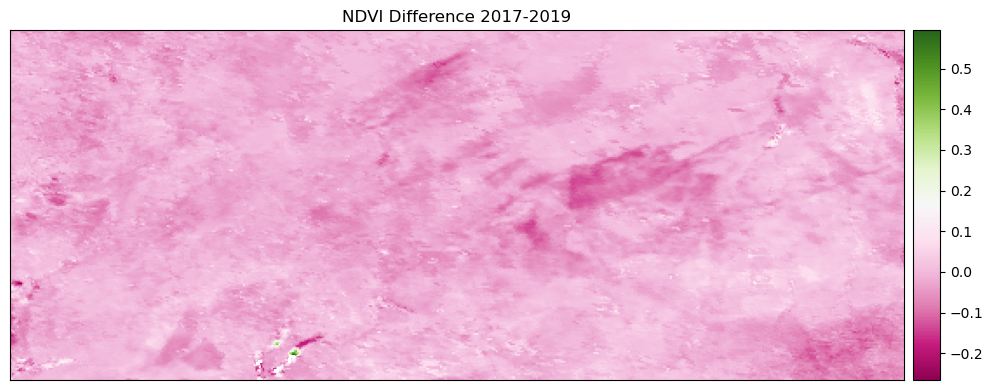

In [35]:
import earthpy.plot as ep
import matplotlib.pyplot as plt
from rasterio.plot import plotting_extent

data_2019 = ndvis_ds.sel(date='2019')

mean_2019 = data_2019.mean(dim='date')

data_2017 = ndvis_ds.sel(date='2017')

mean_2017 = data_2017.mean(dim='date')

difference = mean_2019 - mean_2017
#ndvi_plot_extent = plotting_extent(ndvis_ds.to_array(),
    #ndvis_ds.to_array().rio.transform())

#ax = plt.gca()
# fig = ax.figure
# plot = ax.imshow(difference.to_array().squeeze(), cmap='PiYG')
# ax.set(title='NDVI Difference 2019-2017')
# ep.colorbar(plot)

#camp_gdf.boundary.plot(ax=ax)

ep.plot_bands(difference.to_array().squeeze(), cmap='PiYG', title='NDVI Difference 2017-2019')
plt.show()

In [30]:
# convert envelope of the fire boundary to a GeoDataFrame
# overlay envelope with the camp fire boundary and subtract the two
out_gdf = (
    gpd.GeoDataFrame(geometry=martin_gdf.envelope)
    .overlay(martin_gdf, how="difference")
)
out_gdf

,geometry
0,"MULTIPOLYGON (((-117.47412 41.40109, -117.4741..."


In [31]:
ndvi_fire_ds = ndvis_ds.rio.clip(martin_gdf.geometry)
ndvi_out_ds = ndvis_ds.rio.clip(out_gdf.geometry)

In [32]:
ndvi_fire_df = (
    ndvi_fire_ds.
    groupby(ndvi_fire_ds.date.dt.year)
    .mean(...)
    .NDVI.to_dataframe()[['NDVI']])

ndvi_out_df = (
    ndvi_out_ds.
    groupby(ndvi_out_ds.date.dt.year)
    .mean(...)
    .NDVI.to_dataframe()[['NDVI']])

ndvi_fire_df, ndvi_out_df

(          NDVI
 year          
 2017  0.260148
 2018  0.226782
 2019  0.236916
 2020  0.180761
 2021  0.172890
 2022  0.228318,
           NDVI
 year          
 2017  0.270199
 2018  0.245343
 2019  0.260642
 2020  0.198304
 2021  0.195319
 2022  0.236437)

In [34]:
# Assuming specific_date is the date you want to mark
specific_date = '2018-05-07' 

# Convert the specific date to a decimal year
specific_date = pd.to_datetime(specific_date)
decimal_year = specific_date.year + (specific_date.dayofyear - 1) / 365

# Create your plot
plot = (ndvi_fire_df - ndvi_out_df).hvplot(
    xlabel='Year', ylabel='dNDVI',
    title='Difference in NDVI between inside and outside Martin fire boundary'
)

# Create a vertical line for the specific decimal year
vline = hv.VLine(decimal_year).opts(color='red', line_dash='dashed')

# Overlay the vertical line on the plot
overlayed_plot = plot * vline

overlayed_plot

:Overlay
   .Curve.I :Curve   [year]   (NDVI)
   .VLine.I :VLine   [x,y]

### Vegetation recovered within two years of the Martin fire of 2018

NDVI is not a particulary good measure of vegetation recovery in this grassland dominated ecosystem because NDVI values started low there is not a significant change after the fire and there has not been a significant change since.

In [2]:
%%capture
%%bash
jupyter nbconvert NDVI_alh.ipynb --to html --no-input